# An analysis of excess deaths in Brazil during the COVID-19 pandemics

First lets load the data (scraped by capyvara from the Brasilian civil registry, https://github.com/capyvara/brazil-civil-registry-data):

In [1]:
from excess_deaths import excess_deaths, get_dates
import pandas as pd
import numpy as np
import datetime

df = pd.read_csv("civil_registry_deaths.csv") # Downloaded 2021-03-05 23:08 UTC.

start_date = datetime.date(2020, 3, 1)
end_date = datetime.date(2021, 3, 31)

We can than calculate the total number of excess deaths and plot the total number of deaths.

In [2]:
br_ed = excess_deaths(df, mask=df.city.isnull(), start_date=start_date, end_date=end_date)
br_lower, br_higher, _ = br_ed.count_excess_deaths()
print("Deaths above the mean: {}".format(int(br_higher)))
print("Deaths above the mean plus standard deviation: {}".format(int(br_lower)))

Deaths above the mean: 491586
Deaths above the mean plus standard deviation: 332501


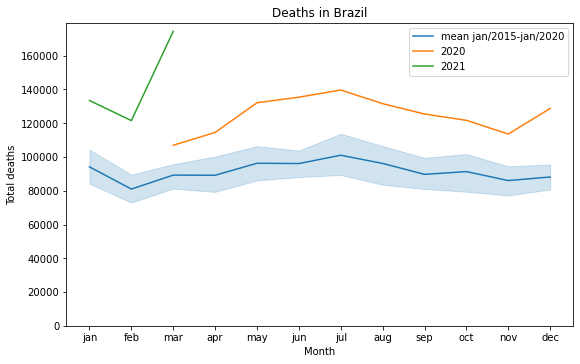

In [3]:
br_ed.plot_deaths(title="Deaths in Brazil", zero_y=True)

## How the number of excess deaths compare to the official number of deaths?

For that let's load the Our World on Data dataset to compare the cumulative number of excess deaths to the confirmed number of deaths.

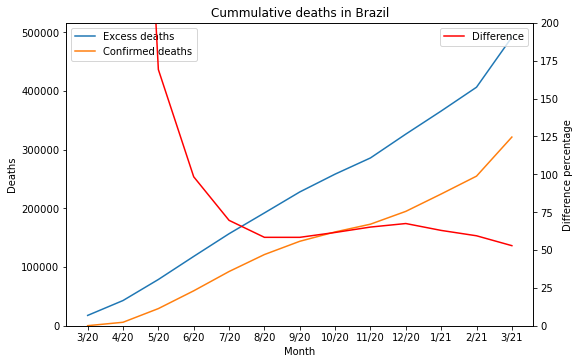

In [4]:
covid_df = pd.read_csv("owid-covid-data.csv")

# Select only valid total_deaths data from Brazil
br_covid_df = covid_df[(covid_df.location == "Brazil") & covid_df.new_deaths.notnull()]

br_ed.plot_excess_deaths_comparison(br_covid_df, "date", "new_deaths", "Confirmed deaths", zero_y=True, ylim=(0, 200), title="Cummulative deaths in Brazil")


## What was the percentage increase (p-score) in deaths in the pandemic period?

We can now plot the p-score.

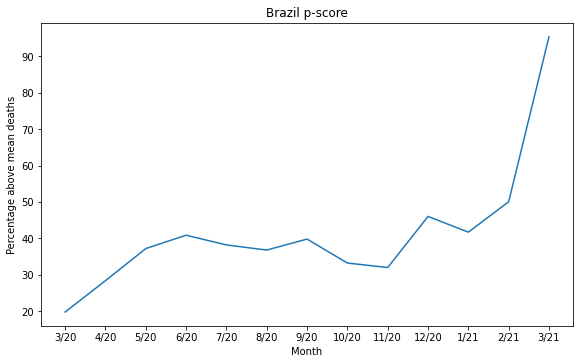

In [5]:
br_ed.plot_p_score(title="Brazil p-score")

## With states had the biggest increase in deaths due to the pandemic?

We can instance an excess_death object for each state and calculate the excess deaths an p-score for each one.

AC deaths above the mean: 1988
AC deaths above the mean plus standard deviation: 1086
AC p-score: 52.35%


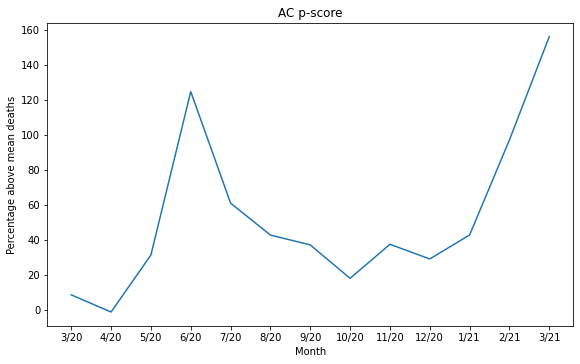


AL deaths above the mean: 7852
AL deaths above the mean plus standard deviation: 3642
AL p-score: 53.06%


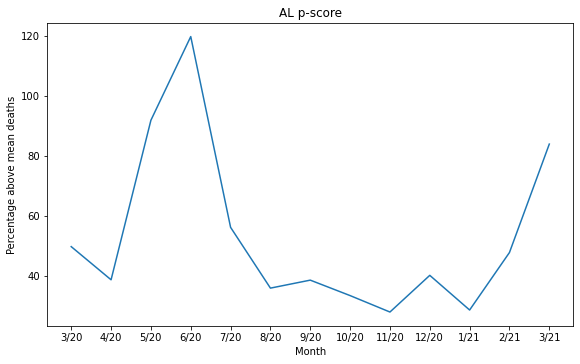


AM deaths above the mean: 18709
AM deaths above the mean plus standard deviation: 13289
AM p-score: 236.71%


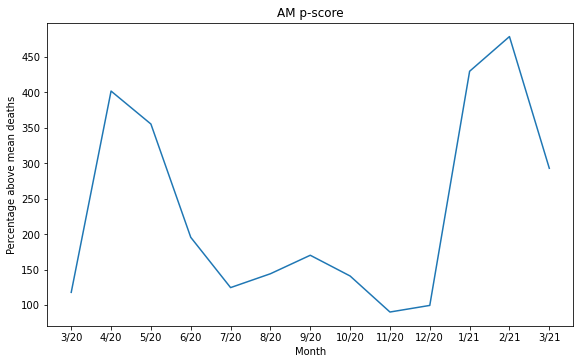


AP deaths above the mean: 864
AP deaths above the mean plus standard deviation: 433
AP p-score: 31.00%


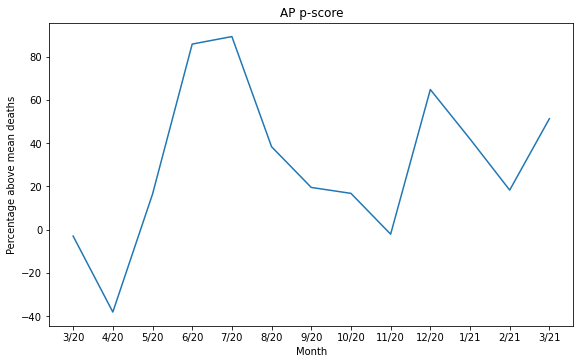


BA deaths above the mean: 31892
BA deaths above the mean plus standard deviation: 19326
BA p-score: 44.66%


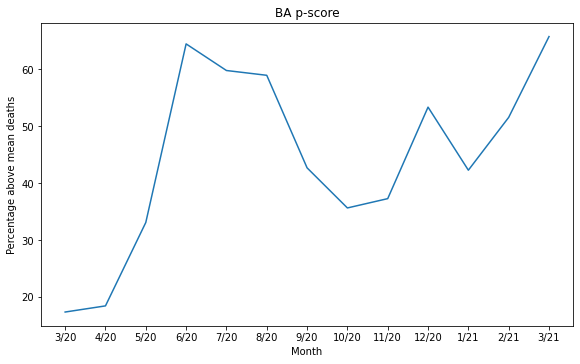


CE deaths above the mean: 28095
CE deaths above the mean plus standard deviation: 12794
CE p-score: 79.37%


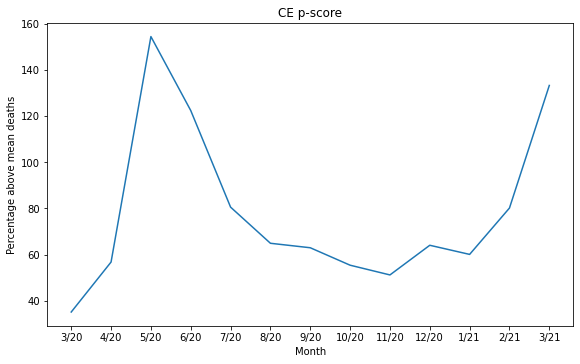


DF deaths above the mean: 5631
DF deaths above the mean plus standard deviation: 4818
DF p-score: 35.89%


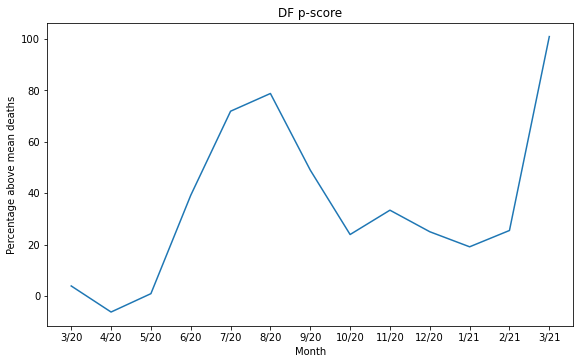


ES deaths above the mean: 7499
ES deaths above the mean plus standard deviation: 6195
ES p-score: 28.79%


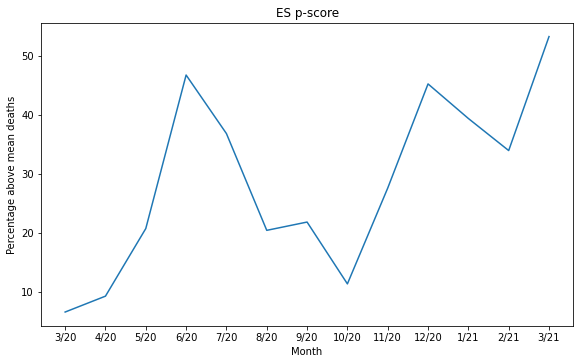


GO deaths above the mean: 16681
GO deaths above the mean plus standard deviation: 12736
GO p-score: 48.81%


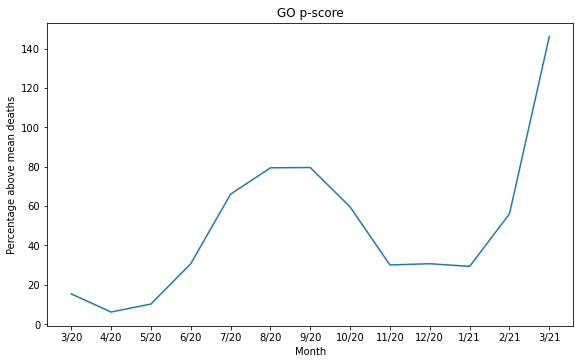


MA deaths above the mean: 20388
MA deaths above the mean plus standard deviation: 11487
MA p-score: 166.07%


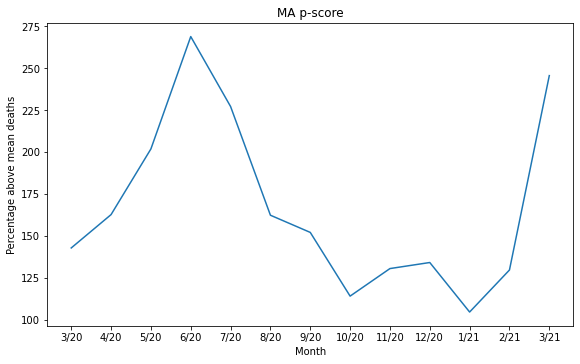


MG deaths above the mean: 30541
MG deaths above the mean plus standard deviation: 21251
MG p-score: 21.58%


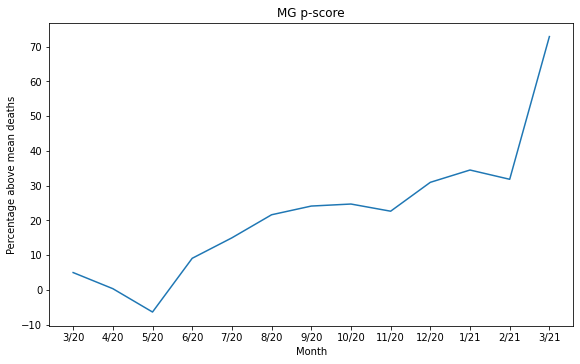


MS deaths above the mean: 6421
MS deaths above the mean plus standard deviation: 2654
MS p-score: 41.41%


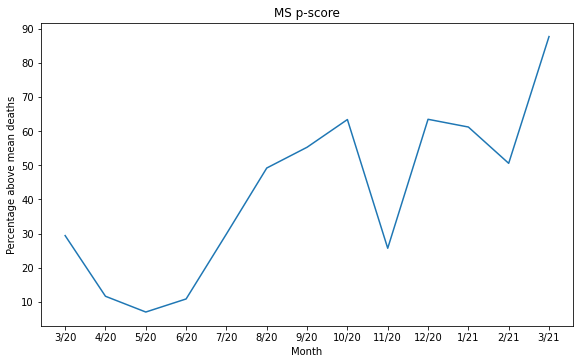


MT deaths above the mean: 6362
MT deaths above the mean plus standard deviation: 4928
MT p-score: 36.97%


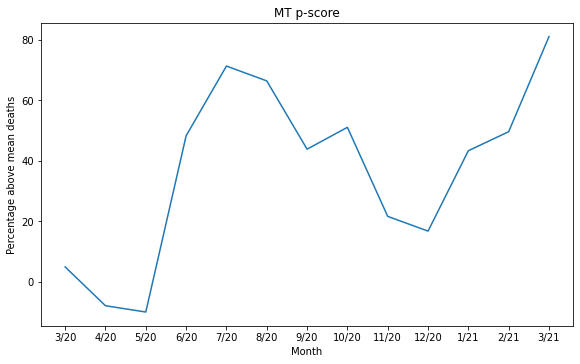


PA deaths above the mean: 21635
PA deaths above the mean plus standard deviation: 11654
PA p-score: 129.57%


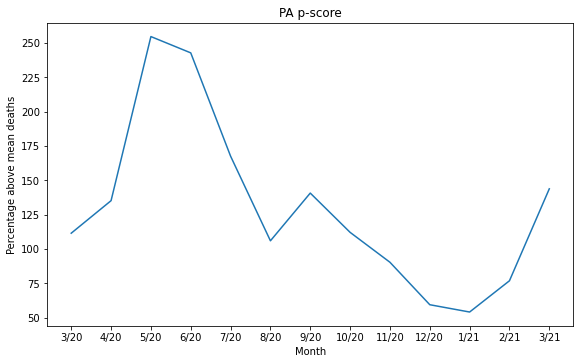


PB deaths above the mean: 7253
PB deaths above the mean plus standard deviation: 3303
PB p-score: 28.06%


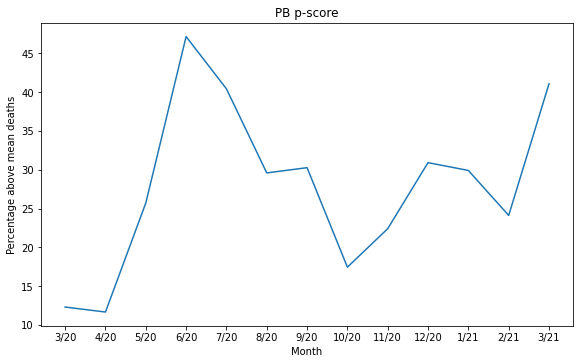


PE deaths above the mean: 16849
PE deaths above the mean plus standard deviation: 10805
PE p-score: 26.39%


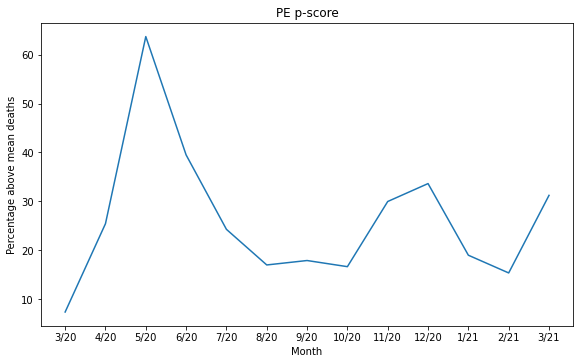


PI deaths above the mean: 7107
PI deaths above the mean plus standard deviation: 1938
PI p-score: 75.74%


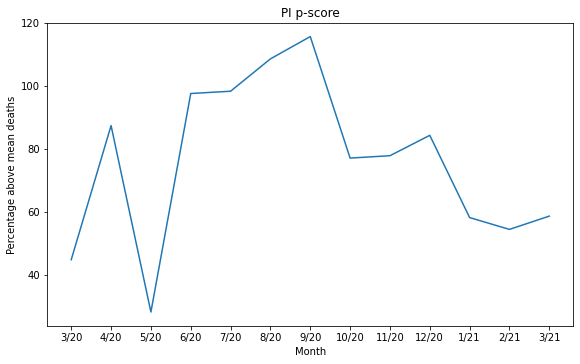


PR deaths above the mean: 13231
PR deaths above the mean plus standard deviation: 9731
PR p-score: 16.54%


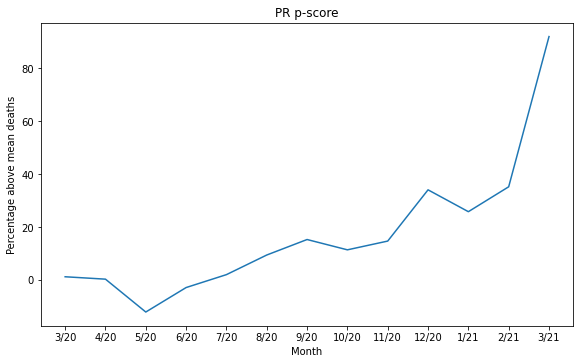


RJ deaths above the mean: 89240
RJ deaths above the mean plus standard deviation: 36553
RJ p-score: 86.49%


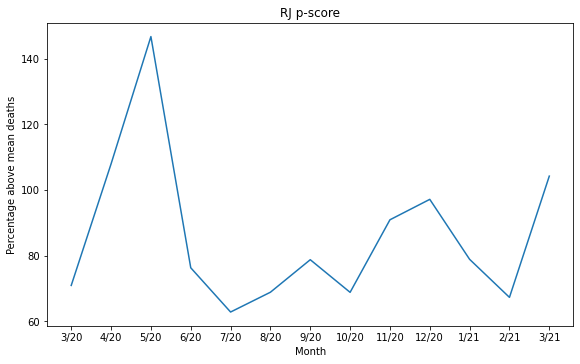


RN deaths above the mean: 9024
RN deaths above the mean plus standard deviation: 3513
RN p-score: 70.03%


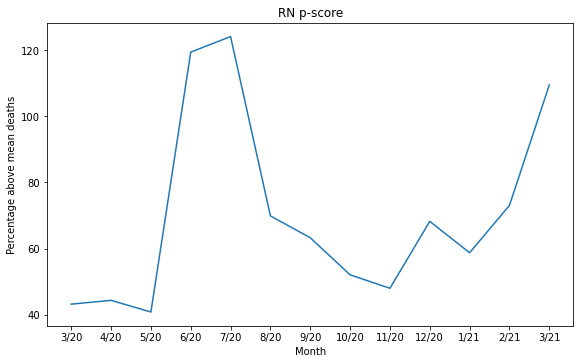


RO deaths above the mean: 4404
RO deaths above the mean plus standard deviation: 2881
RO p-score: 55.52%


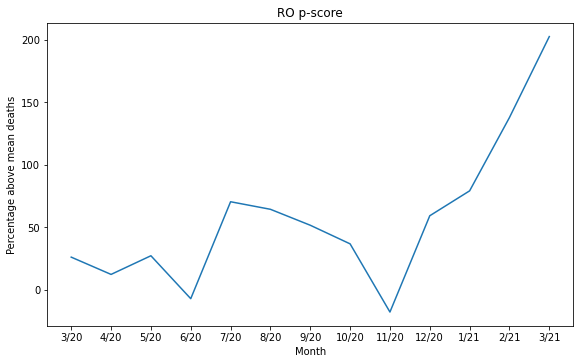


RR deaths above the mean: 1400
RR deaths above the mean plus standard deviation: 691
RR p-score: 70.82%


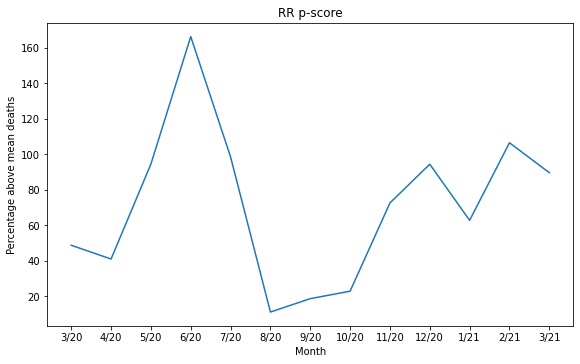


RS deaths above the mean: 31273
RS deaths above the mean plus standard deviation: 18616
RS p-score: 38.36%


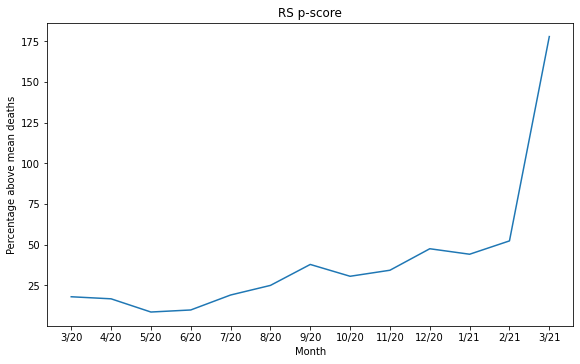


SC deaths above the mean: 14444
SC deaths above the mean plus standard deviation: 9395
SC p-score: 35.80%


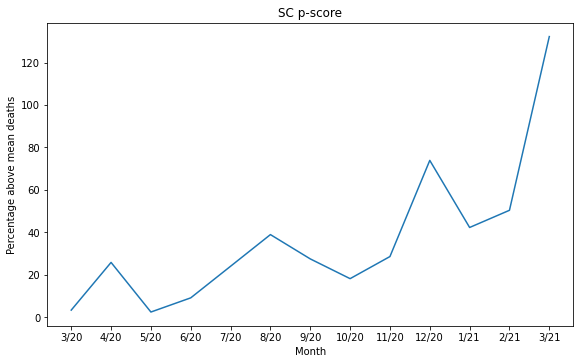


SE deaths above the mean: 2115
SE deaths above the mean plus standard deviation: 847
SE p-score: 15.61%


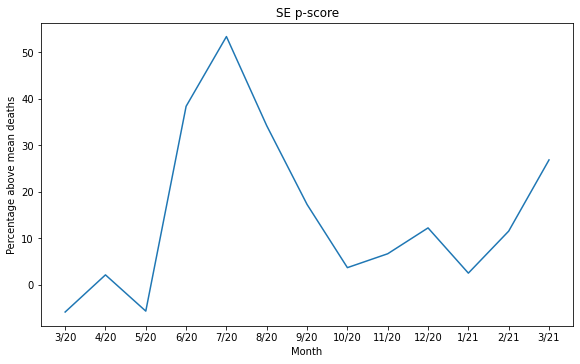


SP deaths above the mean: 87931
SP deaths above the mean plus standard deviation: 70607
SP p-score: 26.91%


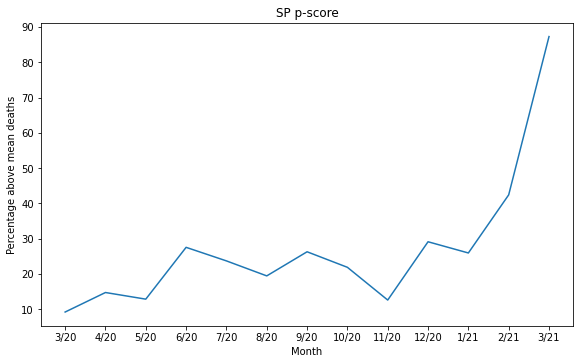


TO deaths above the mean: 2748
TO deaths above the mean plus standard deviation: 1507
TO p-score: 50.36%


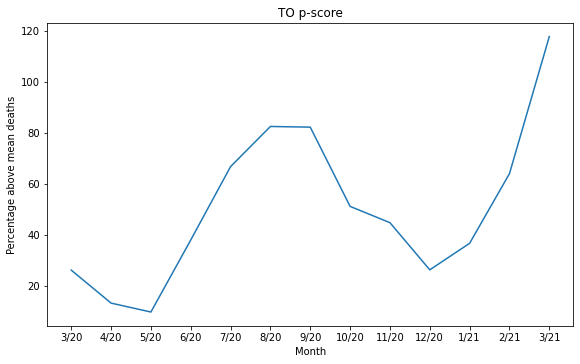

In [6]:
states_ed = {}
states_pscore = {}
for state in df.state.unique():
    state_ed = excess_deaths(df, mask=df.city.isnull() & (df.state == state), start_date=start_date, end_date=end_date)
    lower_ex, higher_ex, mean = state_ed.count_excess_deaths()
    p_score = 100*(higher_ex)/mean
    print("{} deaths above the mean: {}".format(state, int(higher_ex)))
    print("{} deaths above the mean plus standard deviation: {}".format(state, int(lower_ex)))
    print("{} p-score: {:.2f}%".format(state, p_score))
    state_ed.plot_p_score(title="{} p-score".format(state))
    states_ed[state] = state_ed
    states_pscore[state] = p_score
    print("")

And reorder by the p-score to see the states with the biggest relative increase in deaths.

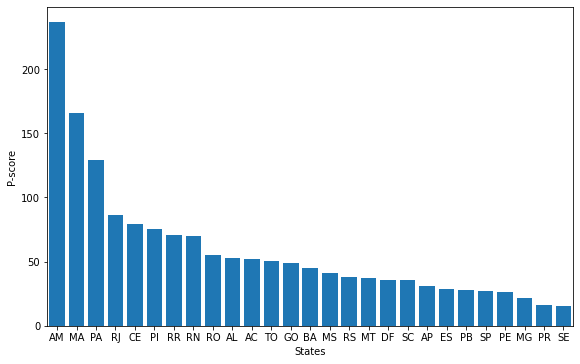

In [7]:
import matplotlib.pyplot as plt

states_pscore = {k: v for k, v in sorted(states_pscore.items(), reverse=True, key=lambda item: item[1])}

br_ed.start_plot()
plt.bar(np.arange(len(states_pscore)), [v for v in states_pscore.values()])
plt.xticks(np.arange(len(states_pscore)), list(states_pscore.keys()))
br_ed.end_plot(xlim=(-0.5, len(states_pscore)-0.5), xlabel="States", ylabel="P-score")

## With cities had the biggest increase in deaths due to the pandemic?

We will exclude cities that does not have:

* At leat 12 months of previous data to use as a mean;
* The data detween `start_date` and `end_date`;
* A cumulative mean deaths to use to compare in the interval `start_date` and `end_date` of at least 100.



In [8]:
from tqdm import tqdm

cities_ed = {}
cities_pscore = {}
errors = []
for city_code in tqdm(df[df.city_ibge_code.notnull()].city_ibge_code.unique()):
    mask = df.city_ibge_code == city_code
    try:
        city_ed = excess_deaths(df, mask=mask, start_date=start_date, end_date=end_date)
    except RuntimeError:
        # This city does not have the required data
        errors.append((city_code, "Not enough data"))
        continue
    lower_ex, higher_ex, mean = city_ed.count_excess_deaths()
    if mean > 100:
        p_score = 100*(higher_ex)/mean
        cities_ed[city_code] = city_ed
        cities_pscore[city_code] = p_score
    else:
        # This city does not have the required mean number of deaths
        errors.append((city_code, "Zero mean"))

100%|██████████| 5004/5004 [02:01<00:00, 41.07it/s]


Lets order the data using the p-score and see the results of the 10 cities with the biggest p-score.

Caxias-MA deaths above the mean: 788
Caxias-MA deaths above the mean plus standard deviation: 568
Caxias-MA p-score: 268.34


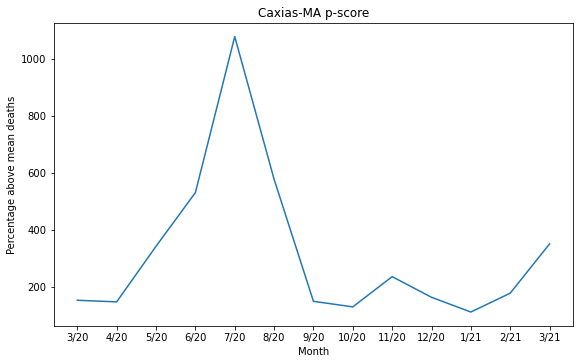


Manaus-AM deaths above the mean: 14964
Manaus-AM deaths above the mean plus standard deviation: 10442
Manaus-AM p-score: 221.13


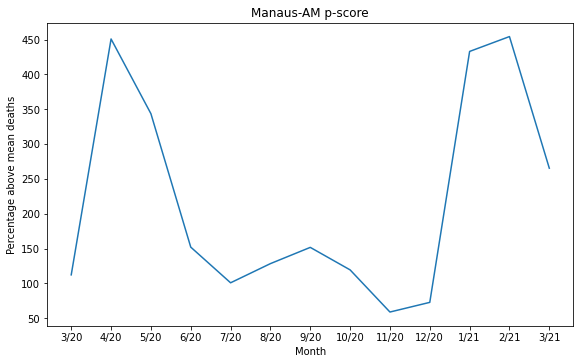


Benevides-PA deaths above the mean: 264
Benevides-PA deaths above the mean plus standard deviation: nan
Benevides-PA p-score: 217.70


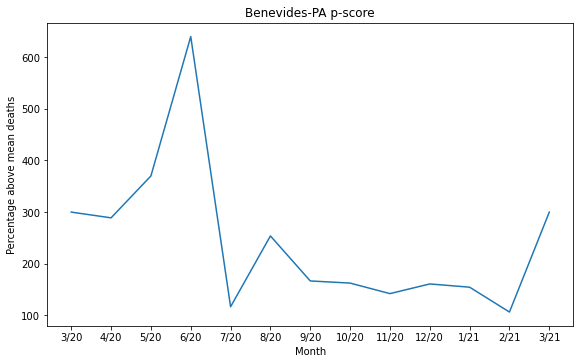


Viçosa do Ceará-CE deaths above the mean: 268
Viçosa do Ceará-CE deaths above the mean plus standard deviation: 196
Viçosa do Ceará-CE p-score: 205.36


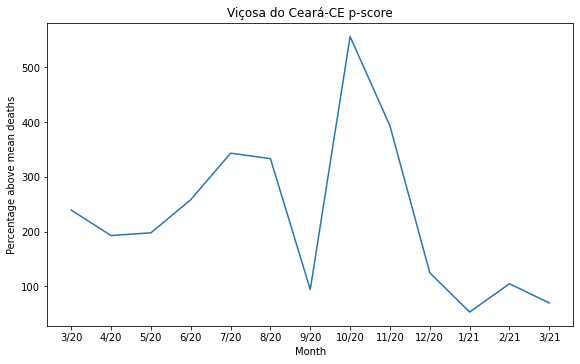


Itacoatiara-AM deaths above the mean: 369
Itacoatiara-AM deaths above the mean plus standard deviation: 191
Itacoatiara-AM p-score: 205.34


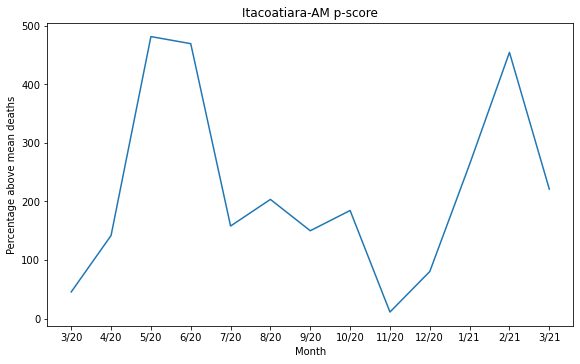


Brejo Santo-CE deaths above the mean: 246
Brejo Santo-CE deaths above the mean plus standard deviation: 69
Brejo Santo-CE p-score: 190.51


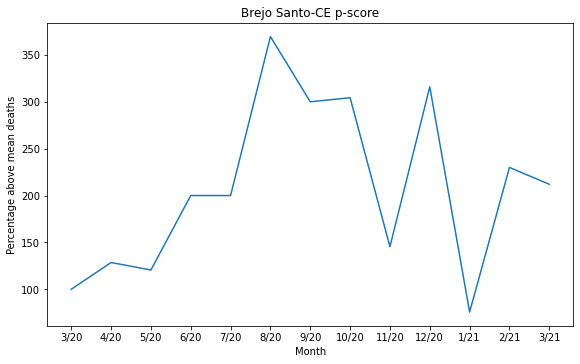


Colinas do Tocantins-TO deaths above the mean: 200
Colinas do Tocantins-TO deaths above the mean plus standard deviation: 133
Colinas do Tocantins-TO p-score: 185.41


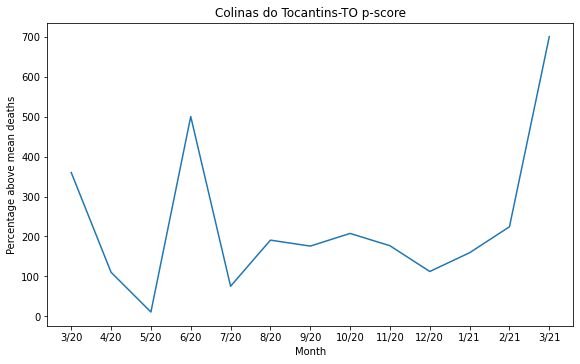


Maricá-RJ deaths above the mean: 1237
Maricá-RJ deaths above the mean plus standard deviation: 780
Maricá-RJ p-score: 185.18


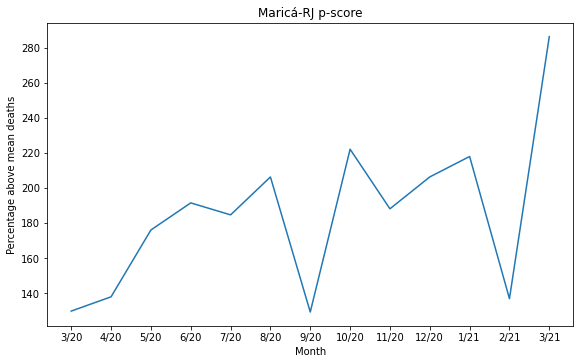


Acopiara-CE deaths above the mean: 190
Acopiara-CE deaths above the mean plus standard deviation: nan
Acopiara-CE p-score: 181.40


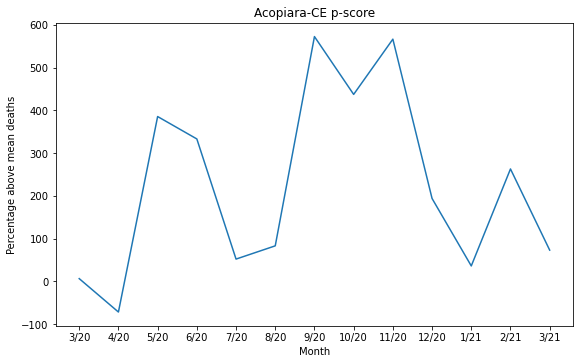


Arraial do Cabo-RJ deaths above the mean: 210
Arraial do Cabo-RJ deaths above the mean plus standard deviation: nan
Arraial do Cabo-RJ p-score: 179.69


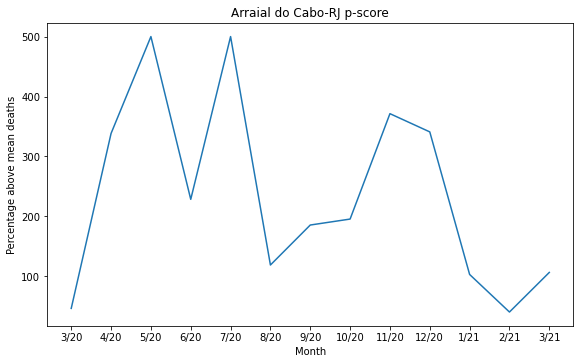

In [9]:
cities_pscore = {k: v for k, v in sorted(cities_pscore.items(), reverse=True, key=lambda item: item[1])}

table = "City\tp-score\tDeaths\n"
for city_code in list(cities_pscore.keys())[:10]:
    city_ed = cities_ed[city_code]
    lower_ex, higher_ex, mean = city_ed.count_excess_deaths()
    mask = df.city_ibge_code == city_code
    city = "{}-{}".format(df[mask].city.iloc[0], df[mask].state.iloc[0])
    print("{} deaths above the mean: {:.0f}".format(city, higher_ex))
    print("{} deaths above the mean plus standard deviation: {:.0f}".format(city, lower_ex))
    print("{} p-score: {:.2f}".format(city, cities_pscore[city_code]))
    table += "{}\t{:.2f}\t{:.0f}\n".format(city, cities_pscore[city_code], higher_ex)
    city_ed.plot_p_score(title="{} p-score".format(city))
    print()